# Definition
## Project Overview
This project will use the confusion EEG dataset hosted on Kaggle at https://www.kaggle.com/wanghaohan/eeg-brain-wave-for-confusion.  This dataset consists of EEG data taken from students watching MOOC courses of varying difficulty.  EEG (or electroencephalogram) is a method of monitoring brain activity by using external electrodes placed on the subjects scalp that can measure voltage fluctuations from large numbers of neurons firing.  While these are not precise enough to measure individual neurons, by 'listening' to the brain as a whole they can get a measurement of the frequencies present.  Modern neural models hypothesize that the frequency that neurons fire encode messages, so we may be able to determine information about what the subject is thinking about by looking at those frequencies.  In particular the device used by the researchers is measuring frequencies in the range of Delta waves (waves with a frequency of 1-3 Hz, or oscillations per second), Theta waves (4-7 Hz), Alpha waves (8-11 Hz), Beta waves (12-29 Hz), and Gamma waves (30-100 Hz).  The device also reports a few proprietary measurements supposedly related to paying attention and meditation, along with the raw signal.  Finally we have labels for each of the videos.  The predifined label is whether the researchers expected the subject to be confused or not, and the self defined label is the self reported level of confusion.  Both of these are reported as binary 0s or 1s.
## Problem Statement
The purpose is to identify signals from the EEG that indicate whether or not the student is confused by the subject matter.  In theory a confusing subject matter should require additional concentration, or at least a different type of focus from the student, which may be observable in the EEG data.  This could be used in a product providing some sort of computer adaptive educational content with a "consumer" level EEG device (which are becoming more and more available).  For instance if it detects that the student is confused, it can slow down the material, provide some more background material, or just give the student more time to consider what they are learning.  In contrast, if the student shows low levels of confusion, it can be more confident in moving forward.  Computer adaptive education is not a new concept, but typically involves a lot of time consuming testing to see if the student has learned the material.  While this probably would not eliminate the need of testing, it could certainly reduce it.  It could also give the product more confidence in its result as it would help identify times when the user may know just enough to answer the questions in the exam, but still has some underlying confusion.  And it could help evaluate the quality of the learning materials by determining whether or not they are clear to the students.
## Metrics
To test any models I build with this data I willl compute the accuracy score.  The researchers providing the dataset report that an accuracy of 65% ends up being "quite decent", so I will try to improve on that.  However I do not expect to be able to do too much better, as I do not expect this dataset to be sufficiently complete in its description of the subject's brain to get perfect (or even near perfect) accuracy.  Further complicating the matter is that the reporting is rather subjective.  The predefined confusion level is not a particularly accurate measurement because it is based on the researchers preconceptions of what the subjects know.  The self reported confusion level is better, but still is limited in that it depends on the user's internal metric for confusion.  There are also perhaps some honesty issues involved, as a student might believe he or she should not be confused on a certain subject even if he or she is, and thus falsely report a 0.  I will also look at the Brier score as it will also look at the probability the model computes by computing what is effectively the mean squared error between the predicted probability of the possitive label and the label itself.  A product using these models could take these proababilities to judge how confident it is on the prediction, thus it makes sense to evaluate how well they perform as well.

# Analysis
## Data Exploration

In [1]:
from pandas import read_csv, concat, DataFrame
from matplotlib import pyplot
%matplotlib inline
import numpy as np
from sklearn.cross_validation import train_test_split, cross_val_score, LabelKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, brier_score_loss, roc_curve
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from IPython.display import display, Markdown

class FigureNum(object):
    """
    Quick function for getting the next figure number
    """
    def __init__(self, label="Figure"):
        self._i = 0
        self.label = label
    
    def next(self):
        self._i+=1
        return self._i
    
    def __str__(self):
        return "### " + self.label + " %i" %self.next()
    
    def markdown(self):
        return Markdown(str(self))
    
    def __int__(self):
        return self.next()

figure_num = FigureNum()
table_num = FigureNum(label="Table")

/home/nick/.pyenvs/confusion/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
raw_data = read_csv("data/EEG data.csv")

Lets first look at this data.

In [3]:
display(table_num.markdown(), raw_data.head()[range(0,9)], raw_data.head()[range(9,15)])
display(table_num.markdown(), raw_data.describe().transpose())

### Table 1

,subject ID,Video ID,Attention,Meditation,Raw,Delta,Theta,Alpha 1,Alpha 2
0,0,0,56,43,278,301963,90612,33735,23991
1,0,0,40,35,-50,73787,28083,1439,2240
2,0,0,47,48,101,758353,383745,201999,62107
3,0,0,47,57,-5,2012240,129350,61236,17084
4,0,0,44,53,-8,1005145,354328,37102,88881


,Beta 1,Beta 2,Gamma1,Gamma2,predefined label,Self-defined label
0,27946,45097,33228,8293,0,0
1,2746,3687,5293,2740,0,0
2,36293,130536,57243,25354,0,0
3,11488,62462,49960,33932,0,0
4,45307,99603,44790,29749,0,0


### Table 2

,count,mean,std,min,25%,50%,75%,max
subject ID,12811.0,4.487394,2.865373,0.0,2.0,4.0,7.0,9.0
Video ID,12811.0,4.390602,2.913232,0.0,2.0,4.0,7.0,9.0
Attention,12811.0,41.313871,23.152953,0.0,27.0,43.0,57.0,100.0
Meditation,12811.0,47.182656,22.655976,0.0,37.0,51.0,63.0,100.0
Raw,12811.0,65.570760,597.921035,-2048.0,-14.0,35.0,90.0,2047.0
Delta,12811.0,605785.261728,637623.562614,448.0,98064.0,395487.0,916623.0,3964663.0
Theta,12811.0,168052.602919,244134.569620,17.0,26917.5,81331.0,205276.0,3007802.0
Alpha 1,12811.0,41384.350636,72430.815187,2.0,6838.0,17500.0,44779.5,1369955.0
Alpha 2,12811.0,33183.393178,58314.100751,2.0,6852.0,14959.0,34550.5,1016913.0
Beta 1,12811.0,24318.368980,38379.684967,3.0,6140.0,12818.0,27406.0,1067778.0


For these purposes I will group the data by session (one subject and one video) and use the values of the brainwaves in each of the reported ranges.  I will not be using the raw data as it doesn't look like there is enough resolution in the data to see individual brain waves on their own.  I will also not use the propriatary measurements.  They are likely computed as a function of the rest of the data, and therefore not likely useful on their own.  Furthermore without knowing how they are computed we would not be able to use them with different equipment.

For the label, I will use the self defined label, since I feel that is more trustworthy.  The predefined labels are making assumptions about how much the students know or how easily they are confused.  

In [4]:
feature_data = raw_data[['subject ID', 'Video ID', "Delta", "Theta", "Alpha 1", "Alpha 2", "Beta 1", "Beta 2", "Gamma1", "Gamma2", 'Self-defined label']]
sessions = feature_data.groupby(['subject ID', 'Video ID'])
display(table_num.markdown())
display(sessions.aggregate(np.max)[:10])

### Table 3

Delta    Theta  Alpha 1  Alpha 2  Beta 1  Beta 2  \
subject ID Video ID                                                       
0          0         2723077  1031826   556251   234589  186966  171258   
           1         3224853   826317   304340   221773  139036  131248   
           2         3958185   961497   400302   123180  221211  145414   
           3         2581211  1698512   251577   236024  174228  176850   
           4         2757383  1011493   167859    90579   95771  144309   
           5         3059285  1330245   850147   396815  231739  192808   
           6         2927619  1811549   143813   122927   89965  100927   
           7         1942380   858788   242933    61527   67659  128280   
           8         2505972  1812829   327389   219596   98671  139751   
           9         3529287  1040266   188482   174153  146567  122511   

                     Gamma1  Gamma2  Self-defined label  
subject ID Video ID                                      
0          0         222111   84108                   0  
           1         141042   84001                   1  
           2         164217   66255                   1  
           3         227196  112579                   0  
           4         181573   49188                   0  
           5         340048  138218                   1  
           6         129326   75859                   1  
           7         131320   41331                   0  
           8         184525  106159                   1  
           9         133563   48166                   0

## Exploratory Visualization
We can try graphing the brainwaves of one of the testing sessions to see how it varies.  Lets look at the brainwave data for subject zero during videos 0 (during which he was not confused) and 1 (during which he was confused).

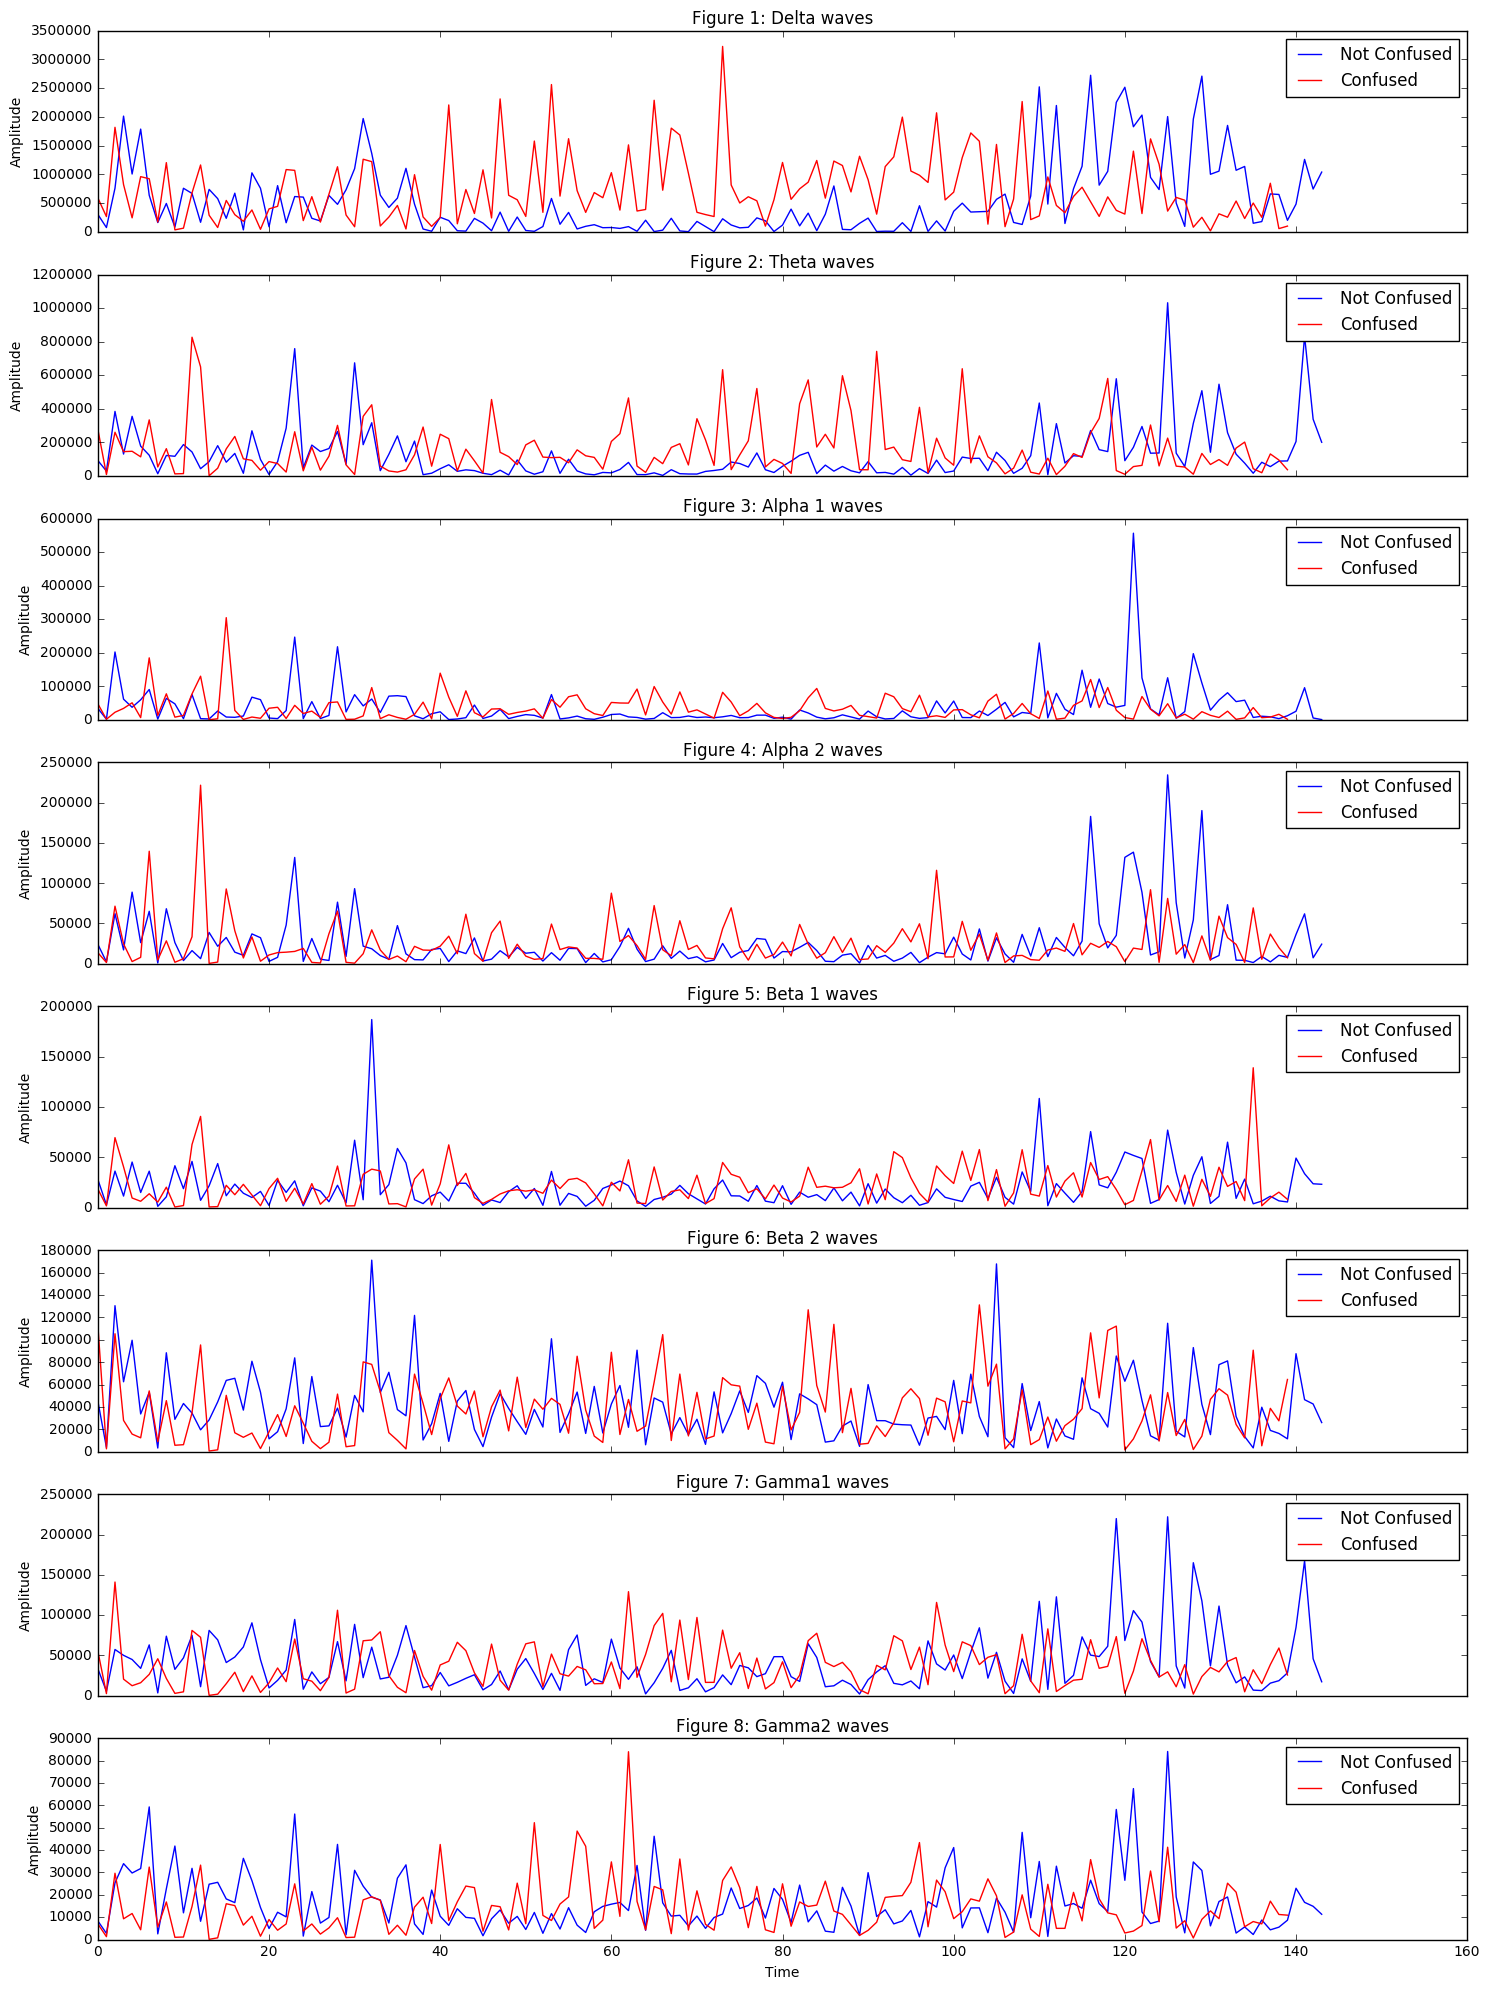

In [5]:
fig, subplots = pyplot.subplots(8, 1, figsize=(15, 20), sharex=True, sharey=False)
pyplot.xlabel("Time")
pyplot.ylabel("Hz")
not_confused = sessions.get_group((0,0))
confused = sessions.get_group((0,1))
waves = ["Delta", "Theta", "Alpha 1", "Alpha 2", "Beta 1", "Beta 2", "Gamma1", "Gamma2"]
for plot, wave in zip(subplots, waves):
    plot.set_title("Figure %i: %s waves" % (figure_num, wave))
    plot.set_ylabel("Amplitude")
    plot.plot(np.arange(len(not_confused)), not_confused[[wave]], 'b', label="Not Confused")
    plot.plot(np.arange(len(confused)), confused[[wave]], 'r', label="Confused")
    plot.legend()
pyplot.tight_layout()

Here we can see some potential differences.  Several of the wavelengths do seem to be increased while the subject was watching the confusing video, particularly in the lower wavelengths.  The difference seems to be greater in the middle of the video, which could mean either there were times being recorded before and after the video, or there was a "warm up" and "cool down" period for each video during which the subject's brain was no longer considering the video.  However, its also possible the higher activity at the end of the lesson that the students understood is a valid signal.

## Algorithms and Techniques

To model the brain waves we will use a gradient boosting ensemble classifier.  These models tend to be robust against overfitting, which given our limited data is a danger.  They can also model multiple paths to a result, which may be neccessary as "confusion" is a vague concept which may show itself in multiple ways.  It is also possible to interpret them to see what features it is using, which can give us both insight in how the brain is working and can validate the model against existing theories of neural activity.

In terms of features, we have a couple of different ways to extract features from this data.  We will aggregate the data for each student/video session to get 100 different data points.  From each data point, we can take both the mean and standard deviation of the frequencies.  The mean will give a measurement of how much activity in that frequency is occuring, while the standard deviation will give us a measurement if it is staying in a certain level or varying over the video.  We can also split the data into different time boxes.  From looking at the visualizations above, there is little difference in the early part of the video, which makes sense as the video would not have had enough time to have an impact on the subjet's brain.  There also looks to be distinct phases in the middle of the video and at the end.  Again, this intuitively makes sense as in the middle of the video the student's brain would be concentrating on understanding what is being presented, while at the end they are more reflecting on what has been said.

## Benchmark

To compare models we will look at their accuracy, which we can compare to what the researchers who provided the data claim is a decent model of 65% accuarcy.  A good model should thus be getting above 70% accuarcy.  We will also look at their brier score to determine how much confidence we can get from the probabilities they are reporting.  Finally we will look at how well the models generalize across different students and across different videos.

# Methadology
## Data preprocessing

The data needs to be aggregated by each student/video.  We will pull out their means and standard deviations.  We will then seperate each session into thirds and find the means for the middle and last third of the videos.

In [6]:
aggregated = sessions.aggregate(np.mean)
cols = aggregated.columns[:-1]
averages = aggregated[cols]
averages.columns = ["Average " + col for col in cols]
target = aggregated[aggregated.columns[-1]]
std_deviations = sessions.aggregate(np.std)[cols]
std_deviations.columns = [col + " STD" for col in cols]

def part_f(f, divisions, part):
    """
    Run f against a part of the data
    @param f: the function to run
    @param divisions: the number of divisions
    @param part: the part from 0 to divisions - 1 to run the function against
    @return: the aggregation function
    """
    def agg(data):
        n = len(data)
        start = part * n / divisions
        end = (part + 1) * n / divisions
        return f(data[start:end])
    return agg

mid_means = sessions.aggregate(part_f(np.mean, 3, 1))[cols]
mid_means.columns = ["Mid %s Mean" % col for col in cols]
late_means = sessions.aggregate(part_f(np.mean, 3, 2))[cols]
late_means.columns = ["Late %s Mean" % col for col in cols]
mid_stds = sessions.aggregate(part_f(np.std, 3, 1))[cols]
mid_stds.columns = ["Mid %s STD" % col for col in cols]
late_stds = sessions.aggregate(part_f(np.std, 3, 2))[cols]
late_stds.columns = ["Late %s STD" % col for col in cols]


## Implementation

First we need a function to evaluate how well a given model performs against a given set of data.  We will run cross validation scoring the accuracy and the brier score of the model.

In [7]:
def get_probability_scores(classifier, features):
    """
    Get the probability of the positive class
    """
    pos_index = classifier.classes_.tolist().index(1)
    return classifier.predict_proba(features)[:,pos_index]

def brier_score(classifier, features, target):
    """
    Find the brier loss score for the classifier
    """
    probabilities = get_probability_scores(classifier, features)
    return brier_score_loss(target, probabilities)

def test_model(classifier, features, target):
    """
    Run the given model against our data
    Report the mean accuracy (high is good) and the mean brier score (low is good)
    """
    accuracy_scores = cross_val_score(classifier, features, target, cv=40, scoring="accuracy")
    brier_scores = cross_val_score(classifier, features, target, cv=40, scoring=brier_score)
    return np.mean(accuracy_scores), np.mean(brier_scores)


We also need to be able to test how well each the model generalizes across different students and different videos.  To do this we will use LabelKFold folds where the label is either the student id or the video id.

In [8]:
def test_fold(fold, classifier, features, target):
    """Test the accuracy of a model against a given fold"""
    train_indexes, test_indexes = fold
    x_train = features.as_matrix()[train_indexes]
    x_test = features.as_matrix()[test_indexes]
    y_train = target.as_matrix()[train_indexes]
    y_test = target.as_matrix()[test_indexes]
    classifier.fit(x_train, y_train)
    predicted = classifier.predict(x_test)
    return accuracy_score(y_test, predicted)


def test_across_students(classifier, features, target, title_post=""):
    """Tests a classifier across different students"""
    student_labels = map(lambda x: x[0], features.index.tolist())
    student_k_fold = LabelKFold(student_labels, 10)
    student_results = [test_fold(fold, classifier, features, target) for fold in student_k_fold]
    student_results.reverse()
    print "Across different students:"
    print "\tmean: %f, standard deviation: %f" % (np.mean(student_results), np.std(student_results))
    student_plot = pyplot.figure()
    student_plot.suptitle("Figure %i: Accuracy Across Students %s" % (figure_num, title_post))
    pyplot.bar(range(10), student_results)
    pyplot.ylim((0,1.0))

def test_across_videos(classifier, features, target, title_post=""):
    """Tests a classifier aginst different videos"""
    video_labels = map(lambda x: x[1], features.index.tolist())
    video_k_fold = LabelKFold(video_labels, 10)
    video_results = [test_fold(fold, classifier, features, target) for fold in video_k_fold]
    video_results.reverse()
    print "Across different videos:"
    print "\tmean: %f, standard deviation: %f" % (np.mean(video_results), np.std(video_results))
    video_plot = pyplot.figure()
    video_plot.suptitle("Figure %i: Accuarcy Across Videos %s" % (figure_num, title_post))
    pyplot.bar(range(10), video_results)
    pyplot.ylim(0,1.0)
    pyplot.show()

We can now look at how the model performs with different combinations of the data.  First lets just look at a classifier looking at mean values.

In [9]:
classifier = GradientBoostingClassifier(random_state=42)

print "Accuracy: %f\nBrier Score: %f" % test_model(classifier, averages, target)

Accuracy: 0.747917
Brier Score: 0.197387


This produces an accuracy of almost 75%, which is pretty good for this data set.  It also produces a Brier score of just below .2.  For reference the Brier score is between 0 and 1 where lower is better, so .2 is a pretty good score.

We also need to evaluate how well this model generalizes.

Across different students:
	mean: 0.580000, standard deviation: 0.172047
Across different videos:
	mean: 0.720000, standard deviation: 0.107703


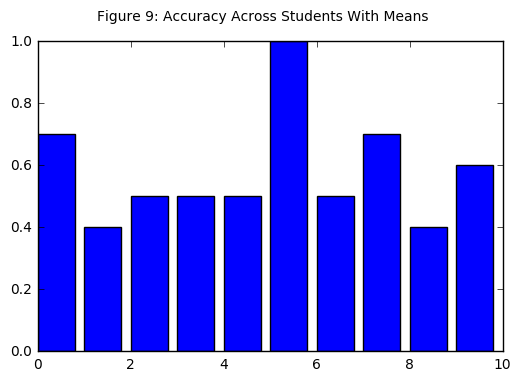

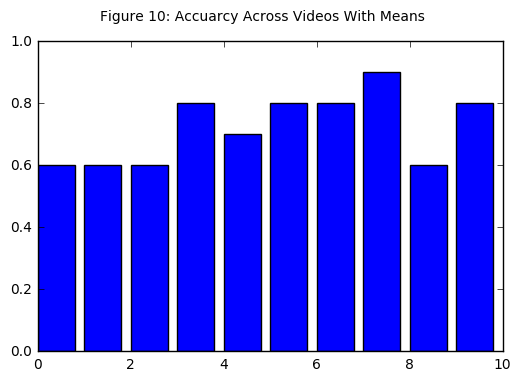

In [10]:
test_across_students(classifier, averages, target, "With Means")
test_across_videos(classifier, averages, target, "With Means")

It generalizes perty well across videos, with the worst accuracy of 60% and several at 80 or 90%.  It does less well across students, where for 6 students it did 50% or worse.

We can look into this algorithm to see what it is keying off of.

In [11]:
def show_feature_importances(classifier, features, target):
    classifier.fit(features, target)
    df = DataFrame(classifier.feature_importances_, index=features.columns).sort_values(0, ascending=False)
    df.columns = ["Importance"]
    display(table_num.markdown(), df)
show_feature_importances(classifier, averages, target)

### Table 4

,Importance
Average Delta,0.209421
Average Theta,0.174372
Average Alpha 2,0.148682
Average Gamma2,0.124358
Average Gamma1,0.108760
Average Alpha 1,0.083931
Average Beta 1,0.077750
Average Beta 2,0.072724


It appears to be focusing primarily on the low frequency delta waves, with theta waves coming in second.  Previous research has suggested that Theta waves are involved in confusion, so this is promising.  It also corresponds to the visualization we did earlier where the delta and theta waves were noticably higher in the confused subjects

## Refinement

Now we can try adding standard deviations to the features.

In [12]:
print "Accuracy: %f\nBrier Score: %f" % test_model(classifier, concat([averages, std_deviations], axis=1), target)

Accuracy: 0.725000
Brier Score: 0.212757


The standard deviation data does not seem to help.  In fact the model performs slightly worse in both accuaracy and the Brier score when they are added.

Now lets try the data separated out into the both mid and late features.

In [13]:
time_separated = concat([mid_means, late_means], axis=1)
print "Accuracy: %f\nBrier Score: %f" % test_model(classifier, time_separated, target)

Accuracy: 0.760417
Brier Score: 0.185906


The model seems to be doing slightly better.  Now lets also look at how well it generalizes.

Across different students:
	mean: 0.610000, standard deviation: 0.234307
Across different videos:
	mean: 0.740000, standard deviation: 0.120000


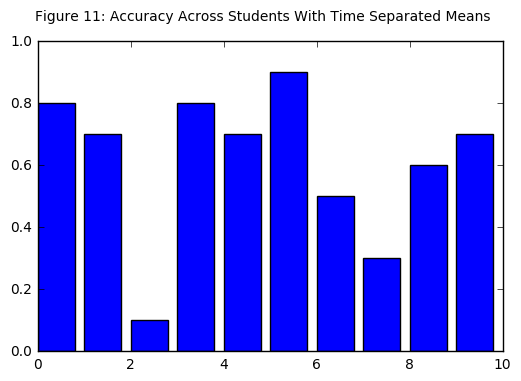

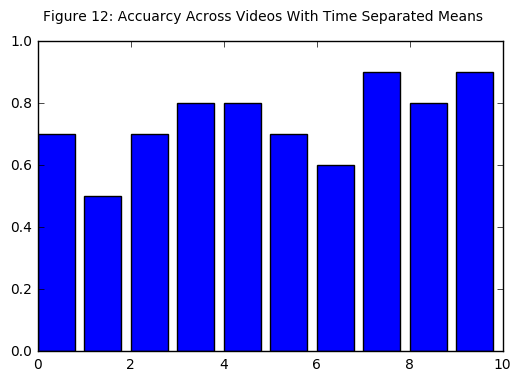

In [14]:
test_across_students(classifier, time_separated, target, "With Time Separated Means")
test_across_videos(classifier, time_separated, target, "With Time Separated Means")

On average these models seem to be generalizing better both against videos and students, however across students it varies quote a bit.  While for 6 students it did 70% or better, for one student it is correct only 30% of the time, and for another it is correct only 10 percent of the time.

We can look at what features the model is using with this feature set.

In [15]:
show_feature_importances(classifier, time_separated, target)

### Table 5

,Importance
Mid Theta Mean,0.183342
Mid Alpha 2 Mean,0.178386
Late Delta Mean,0.082603
Mid Gamma2 Mean,0.078203
Late Beta 1 Mean,0.071403
Mid Beta 1 Mean,0.068555
Mid Alpha 1 Mean,0.066921
Mid Delta Mean,0.051486
Late Gamma2 Mean,0.051451
Late Theta Mean,0.031990


The most important features are the theta and upper alpha waves during the middle of the video.  The top scoring waves during the latter third of the video are delta waves, but they are quite a bit lower than the theta and alpha 2 waves.

Since its possible we are getting some false signals at the end of the video (for instance if the video has completed), lets also look at just the middle part.

In [16]:
print "Accuracy: %f\nBrier Score: %f" % test_model(classifier, mid_means, target)

Accuracy: 0.783333
Brier Score: 0.179587


Here it is doing noticably better in terms of both accuracy and the Brier score.  If we then look at its generalization:

Across different students:
	mean: 0.670000, standard deviation: 0.190000
Across different videos:
	mean: 0.780000, standard deviation: 0.107703


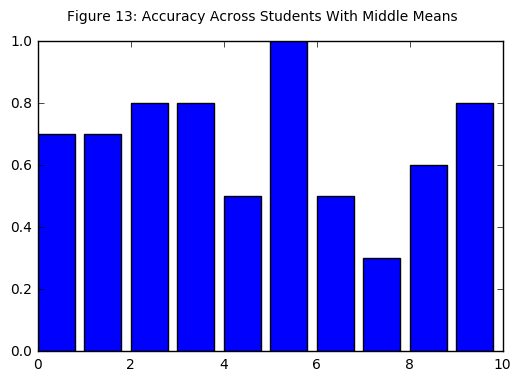

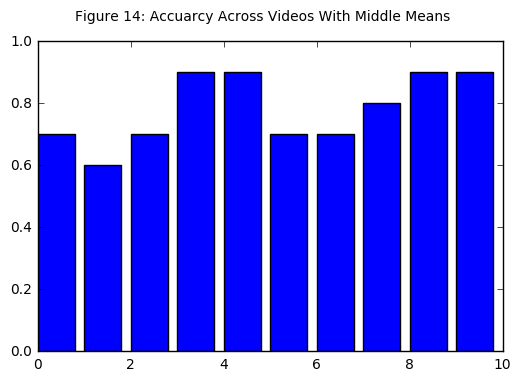

In [17]:
test_across_students(classifier, mid_means, target, "With Middle Means")
test_across_videos(classifier, mid_means, target, "With Middle Means")

Across videos it is generalizing quite well, with 4 videos showing 90% accuracy, and all but one show 70% or above.  In terms of students it is doing better than any of the other feature sets, though still worse than across the videos.

Now lets look at how important it is treating each feature.

In [18]:
show_feature_importances(classifier, mid_means, target)

### Table 6

,Importance
Mid Alpha 2 Mean,0.215272
Mid Theta Mean,0.203108
Mid Gamma2 Mean,0.152900
Mid Delta Mean,0.103543
Mid Beta 1 Mean,0.097387
Mid Gamma1 Mean,0.082917
Mid Beta 2 Mean,0.081064
Mid Alpha 1 Mean,0.063809


The upper alpha and theta waves show to be the most important.  Again, theta waves are expected as previous research has suggested it should be important.  The importance of alpha waves is somewhat surprising, especially since there is a clear difference between upper and lower alpha waves

We can now try looking at the middle video means combined with their standard deviations to see if that gives us an improvement.

Accuracy: 0.787500
Brier Score: 0.170951
Across different students:
	mean: 0.700000, standard deviation: 0.167332
Across different videos:
	mean: 0.770000, standard deviation: 0.118743


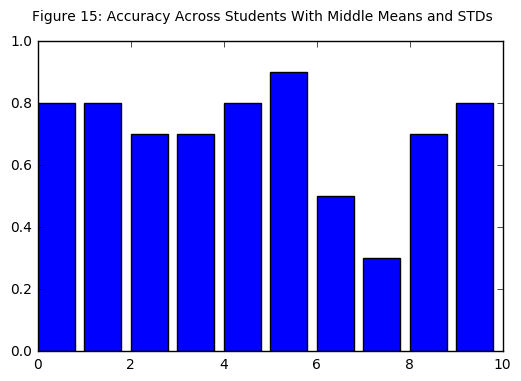

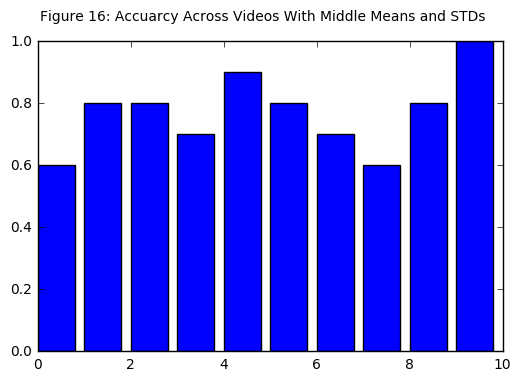

In [19]:
mid_means_and_stds = concat([mid_means, mid_stds], axis=1)
print "Accuracy: %f\nBrier Score: %f" % test_model(classifier, mid_means_and_stds, target)
test_across_students(classifier, mid_means_and_stds, target, "With Middle Means and STDs")
test_across_videos(classifier, mid_means_and_stds, target, "With Middle Means and STDs")

This doesn't change the accuracy or brier score much overall, but it is now a bit more consistent across students. 
There are now only two students which are getting below 70% accuracy.  Overall video accuracy is slightly lower, though now only 4 of them have an accuracy below 0.8

We can take a look at what features it is now looking at.

In [20]:
show_feature_importances(classifier, mid_means_and_stds, target)

### Table 7

,Importance
Mid Alpha 2 Mean,0.225020
Mid Gamma2 STD,0.141188
Mid Gamma2 Mean,0.118993
Mid Theta Mean,0.103224
Mid Theta STD,0.069433
Mid Beta 1 STD,0.067186
Mid Beta 1 Mean,0.043637
Mid Gamma1 STD,0.040002
Mid Alpha 1 STD,0.034248
Mid Alpha 1 Mean,0.032340


Interestingly now upper Gamma waves are more important, and theta waves have decreased importance

We can also investigate adjusting hyperparameters for this model.

In [21]:
for i in [25, 50, 100, 200, 400]:
    accuracy, brier = test_model(GradientBoostingClassifier(random_state=42, n_estimators=i),
                        mid_means_and_stds, target)
    print "%i: %f, %f" % (i, accuracy, brier)

25: 0.810417, 0.170246
50: 0.812500, 0.165893
100: 0.787500, 0.170951
200: 0.781250, 0.185788
400: 0.781250, 0.193584


We can see here that the smaller number of estimators performs better, with both 50 and 25 showing an accuracy of above 80%, and 50 with a brier score below 0.17.  This suggests the model is overfitting with the higher number of estimators.

We can also try varying the max depth.

In [22]:
for i in [1,2,3,4,5]:
    accuracy, brier = test_model(GradientBoostingClassifier(random_state=42, n_estimators=50, max_depth=i),
                       mid_means_and_stds, target)
    print "%i: %f, %f" % (i, accuracy, brier)

1: 0.779167, 0.169929
2: 0.787500, 0.172029
3: 0.812500, 0.165893
4: 0.793750, 0.188110
5: 0.741667, 0.218296


Here it appears a max depth of 3 (which happens to be the default value) is optimal.
Finally we can adjust the learning rate

In [23]:
for i in [0.05, 0.075, 0.1, 0.125, 0.15]:
    accuracy, brier = test_model(GradientBoostingClassifier(random_state=42, n_estimators=50, max_depth=3,
                                                            learning_rate=i),  mid_means_and_stds, target)
    print "%.3f: %f, %f" % (i, accuracy, brier)

0.050: 0.810417, 0.168559
0.075: 0.800000, 0.168080
0.100: 0.812500, 0.165893
0.125: 0.781250, 0.171069
0.150: 0.781250, 0.168364


Again, the default value of 0.1 appears to be a good parameter.

# Results
## Model Evaluation and Validation
With the new parameters we can again check to see what features its looking at.

In [24]:
optimized_classifier = GradientBoostingClassifier(random_state=42, n_estimators=50, max_depth=3, learning_rate=.1)
show_feature_importances(optimized_classifier, mid_means_and_stds, target)

### Table 8

,Importance
Mid Alpha 2 Mean,0.256545
Mid Theta Mean,0.160155
Mid Gamma2 STD,0.151073
Mid Theta STD,0.087094
Mid Gamma2 Mean,0.081805
Mid Beta 1 STD,0.079264
Mid Gamma1 STD,0.057449
Mid Alpha 1 Mean,0.031012
Mid Beta 2 STD,0.023794
Mid Beta 1 Mean,0.018960


The biggest change from before is an increased importance on theta waves.  They remain less important than upper alpha waves, but the combined importance of their mean and standard deviation are very close to those of alpha 2 waves.
Now we can investigate how well the newly optimized model generalizes.

Across different students:
	mean: 0.680000, standard deviation: 0.177764
Across different videos:
	mean: 0.770000, standard deviation: 0.118743


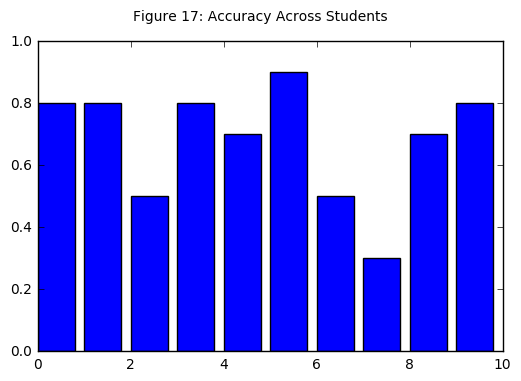

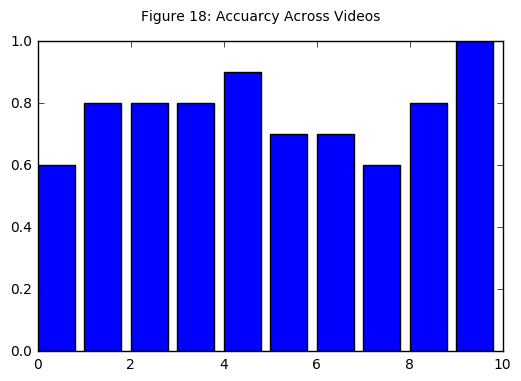

In [25]:
test_across_students(optimized_classifier, mid_means_and_stds, target)
test_across_videos(optimized_classifier, mid_means_and_stds, target)

It generalizes just as well across videos, and almost as well across different students.

## Justification
We are getting an overall accuracy of over 80%, which is significantly better than the 65% percent reported by the researchers as a "decent model" or the 70% I identified as my goal.  This model seems to do very well across different videos, though it remains inconsistent across different students.  This is not too unexpected, as different brains do work differently.  However it means that any use of neural data for confusion will need to do some calibration for a new student.

# Conclusion
## Visualization
To get a better idea of how well this model performs, we can look at the ROC curve it generates

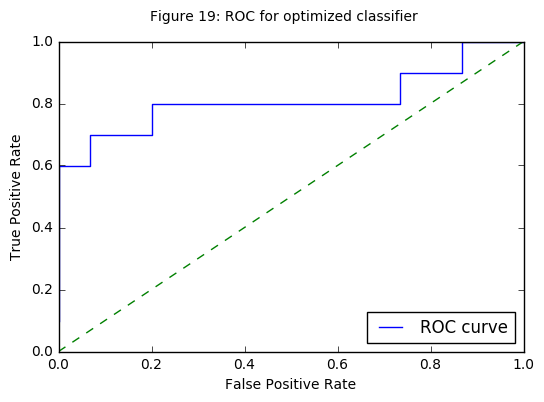

In [26]:
def draw_roc(classifier, x, y, title):
    train_x, test_x, train_y, test_y = train_test_split(x, y, random_state=42)
    classifier.fit(train_x, train_y)
    probabilities = get_probability_scores(classifier, test_x)
    fpr, tpr, thresholds = roc_curve(test_y, probabilities)
    roc_plot = pyplot.figure()
    roc_plot.suptitle(title)
    pyplot.plot(fpr, tpr, label="ROC curve")
    pyplot.plot([0,1], [0,1], linestyle="--")
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend(loc="lower right")
    pyplot.show()
draw_roc(optimized_classifier, mid_means_and_stds, target, "Figure %i: ROC for optimized classifier" % figure_num)

The model is taking particular interest in the Alpha 2 and Theta waves.  We can plot them to get a visualization of how they appear in different sessions.

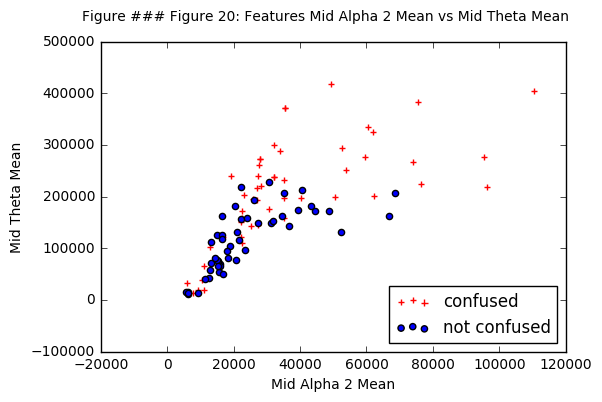

In [27]:
def plot_features(features, target, x_feature, y_feature):
    """
    Plots the features 
    """
    pos_features = features[target == 1.0]
    neg_features = features[target == 0.0]
    pyplot.scatter(pos_features[x_feature], pos_features[y_feature], marker='+', c='r', label='confused')
    pyplot.scatter(neg_features[x_feature], neg_features[y_feature], marker='o', c='b', label='not confused')
    pyplot.xlabel(x_feature)
    pyplot.ylabel(y_feature)
    pyplot.legend(loc='lower right')
    pyplot.suptitle("Figure {figure_num}: Features {x} vs {y}".format(figure_num=figure_num,
                                                                      x=x_feature, y=y_feature))
    pyplot.show()
    
plot_features(mid_means_and_stds, target, 'Mid Alpha 2 Mean', 'Mid Theta Mean')    

Here we can get a good idea as to why the model is treating both of these features with high importance.  They are roughly correlated, with higher values of both being associated with confusion.

## Reflection
For this project I was able to make a well performing model for determining if a student was confused by a video based solely on their brain waves as detected by an EEG.  A Gradient Boosting Ensemble model, looking at both the mean and standard deviations of the amplitudes of brain waves within 8 different frequency ranges during the middle of the video, is able to achieve an accuracy of around 80%.  By looking at the model we can also get an idea of what features are important in determining if a student is confused.  Previous research had suggested the importance of theta waves, but this model is also considering upper alpha and upper gamma waves.

## Improvement
As successful as this model is, it is based on very limited data.  We only have 10 different students and 10 different videos resulting in 100 different data points.  A wider selection of data would make for a more robust dataset.  

Furthermore we are grading the confusion levels with a very course grained and subjective evaluation.  Different students will have different internal metrics for what "confusion" means, and we don't really get to take in consideration the level of confusion a student has.  It may be some of the false predictions involved students who were on the threshold of being confused or not.  A continuous confusion level modeled with a regression model may be able to capture some of that.  And if the confusion level were captured in a more objective fashion (such as giving the student a short quiz on the material) we may be able to be more confident in the results.